<a href="https://colab.research.google.com/github/NathanielRose/eeg-294/blob/master/Gumpy_Testing_SH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
!pip install git+git://github.com/gumpy-bci/gumpy.git

  Cloning git://github.com/gumpy-bci/gumpy.git to /tmp/pip-req-build-5z3wg2so
  Running command git clone -q git://github.com/gumpy-bci/gumpy.git /tmp/pip-req-build-5z3wg2so
  Created wheel for gumpy: filename=gumpy-0.5.0-cp36-none-any.whl size=32999 sha256=80d8609705c06b4656244a8edb55369289194cdbb0d1910743a98e4be74e0ec8
  Stored in directory: /tmp/pip-ephem-wheel-cache-46x3oibn/wheels/cf/ee/4d/dfa04a0d04ffb1ca36f436f3fef4817e9e23bfec03dd772913
Successfully built gumpy


In [0]:
!git clone https://github.com/NathanielRose/eeg-294.git

Cloning into 'eeg-294'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 117 (delta 30), reused 86 (delta 11), pack-reused 0
Receiving objects: 100% (117/117), 684.71 KiB | 15.22 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [0]:
##Import packages##

%reset
%matplotlib inline

from __future__ import print_function
import os; os.environ["THEANO_FLAGS"] = "device=gpu0"
import os.path
from datetime import datetime
import sys

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [0]:
##import gumpy modules##
sys.path.append('gumpy/gumpy/')
import gumpy

sys.path.append('eeg-294/gumpy-deeplearning')
import models

sys.path.append('eeg-294/gumpy-deeplearning/models/')
import utils

Using TensorFlow backend.


In [0]:
##Setup parameters##
DEBUG = True
CLASS_COUNT = 2
DROPOUT = 0.2   # dropout rate in float

# parameters for filtering data
FS = 250
LOWCUT = 2
HIGHCUT = 60
ANTI_DRIFT = 0.5
CUTOFF = 50.0 # freq to be removed from signal (Hz) for notch filter
Q = 30.0  # quality factor for notch filter 
W0 = CUTOFF/(FS/2)
AXIS = 0

#set random seed
SEED = 42
KFOLD = 5

# Get Data

In [0]:
%%bash

export fileid=1DS64UOrt9wzswke5wiFtat94-s1YcRmb
export filename=grazdata.zip


wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='$fileid -O- \
     | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt

wget --load-cookies cookies.txt -O $filename \
     'https://docs.google.com/uc?export=download&id='$fileid'&confirm='$(<confirm.txt)

--2019-11-14 16:38:32--  https://docs.google.com/uc?export=download&id=1DS64UOrt9wzswke5wiFtat94-s1YcRmb
Resolving docs.google.com (docs.google.com)... 172.217.204.113, 172.217.204.138, 172.217.204.102, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘STDOUT’

     0K ...                                                    16.0M=0s

2019-11-14 16:38:32 (16.0 MB/s) - written to stdout [3248]

--2019-11-14 16:38:32--  https://docs.google.com/uc?export=download&id=1DS64UOrt9wzswke5wiFtat94-s1YcRmb&confirm=7G8A
Resolving docs.google.com (docs.google.com)... 172.217.204.113, 172.217.204.138, 172.217.204.102, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ubhikfjh0o

In [11]:
!unzip grazdata.zip

Archive:  grazdata.zip
mapname:  conversion of  failed
replace B03T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace B05E.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace B04T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace B01E.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace B04E.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace B06T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace B08T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace B07T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace B02T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace B03E.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace B09T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace B05T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace B09E.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace B01T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: B01T.mat                
 extracting: B06E.mat                
 extracting: B07E.mat                
 extracting: B08E.m

In [13]:
!unzip grazdata

Archive:  grazdata.zip
mapname:  conversion of  failed
replace B03T.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: B03T.mat                
 extracting: B05E.mat                
 extracting: B04T.mat                
 extracting: B01E.mat                
 extracting: B04E.mat                
 extracting: B06T.mat                
 extracting: B08T.mat                
 extracting: B07T.mat                
 extracting: B02T.mat                
 extracting: B03E.mat                
 extracting: B09T.mat                
 extracting: B05T.mat                
 extracting: B09E.mat                
 extracting: B01T.mat                
 extracting: B06E.mat                
 extracting: B07E.mat                
 extracting: B08E.mat                
 extracting: B02E.mat                


In [19]:
#load data
subj = 'B01E'

grazb_data = gumpy.data.GrazB('', subject)
grazb_data.load()

In [20]:
grazb_data.print_stats()

Data identification: GrazB-B01
EEG-data shape: (1626266, 3)
Trials data shape:  (324,)
Labels shape:  (324,)
Total length of single trial:  8
Sampling frequency of EEG data: 250
Interval for motor imagery in trial:  [4, 7]
Classes possible:  [0 1]


# Postprocess

## Notch and Band-Pass Filters

In [0]:
# this returns a butter-bandpass filtered version of the entire dataset
btr_data = gumpy.signal.butter_bandpass(grazb_data, lo=2, hi=60)



## Normalization

In [21]:
# normalize the data first
norm_data = gumpy.signal.normalize(grazb_data, 'mean_std')
# let's see some statistics
print("""Normalized Data:
  Mean    = {:.3f}
  Min     = {:.3f}
  Max     = {:.3f}
  Std.Dev = {:.3f}""".format(
  np.nanmean(norm_data),np.nanmin(norm_data),np.nanmax(norm_data),np.nanstd(norm_data)
))

Normalized Data:
  Mean    = -0.000
  Min     = -21.830
  Max     = 14.876
  Std.Dev = 1.000


## Feature Extraction 

Text(0.5, 1.0, ' Filtered Data')

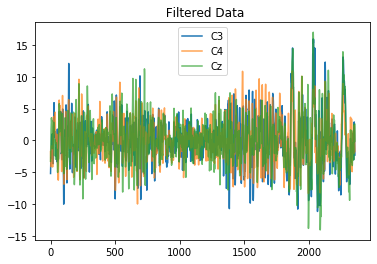

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt 

# Plot after filtering with a butter bandpass (ignore normalization)
plt.figure()
plt.clf()
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 0], label='C3')
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 1], alpha=0.7, label='C4')
plt.plot(btr_data[grazb_data.trials[0]: grazb_data.trials[1], 2], alpha=0.7, label='Cz')
plt.legend()
plt.title(" Filtered Data")

## EEG band visualization

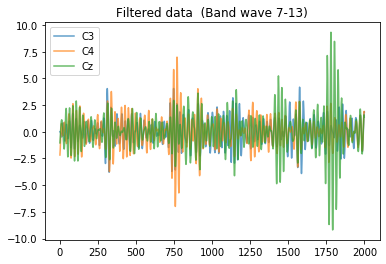

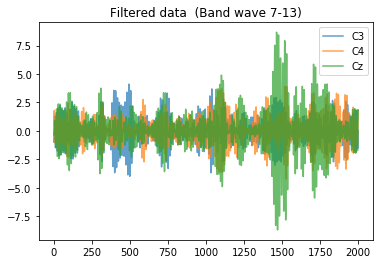

In [30]:
# determine the trial that we wish to plot
n_trial = 120
# now specify the alpha and beta cutoff frequencies
lo_a, lo_b = 7, 16
hi_a, hi_b = 13, 24

# first step is to filter the data
flt_a = gumpy.signal.butter_bandpass(grazb_data, lo=lo_a, hi=hi_a)
flt_b = gumpy.signal.butter_bandpass(grazb_data, lo=lo_b, hi=hi_b)

# finally we can visualize the data
gumpy.plot.EEG_bandwave_visualizer(grazb_data, flt_a, n_trial, lo_a, hi_a)
gumpy.plot.EEG_bandwave_visualizer(grazb_data, flt_b, n_trial, lo_a, hi_a)

## Extract Trials

In [0]:
# retrieve the trials from the filtered data. This requires that the function
# knows the number of trials, labels, etc. when only passed a (filtered) data matrix
trials = grazb_data.trials
labels = grazb_data.labels
sampling_freq = grazb_data.sampling_freq
data_class_a = gumpy.utils.extract_trials(flt_a, trials=trials, labels=labels, sampling_freq=sampling_freq)

# it is also possible to pass an instance of Dataset and filtered data.
# gumpy will then infer all necessary details from the dataset
data_class_b = gumpy.utils.extract_trials(grazb_data, flt_b)

# similar to other functions, this one allows to pass an entire instance of Dataset
# to operate on the raw data
data_class1 = gumpy.utils.extract_trials(grazb_data)

## Visualize Classes

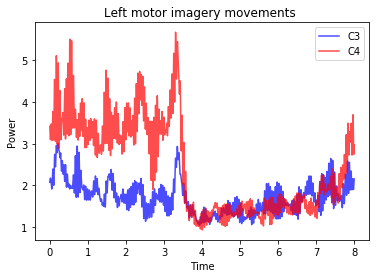

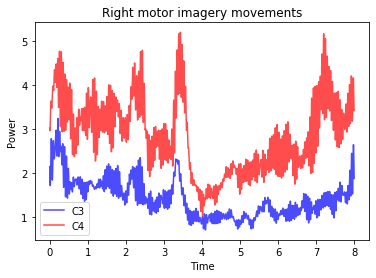

In [32]:
# specify some cutoff values for the visualization
lowcut_a, highcut_a = 14, 30
# and also an interval to display
interval_a = [0, 8]
# visualize logarithmic power?
logarithmic_power = False

# visualize the extracted trial from above
gumpy.plot.average_power(data_class_a, lowcut_a, highcut_a, interval_a, grazb_data.sampling_freq, logarithmic_power)

## Wavelet Transform

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6cd16e44e0>,
      dtype=object)

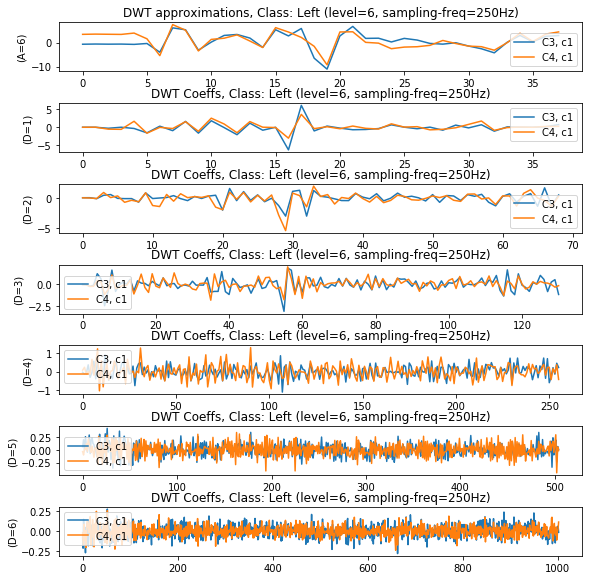

In [33]:
# As with most functions, you can pass arguments to a 
# gumpy function that will be forwarded to the backend.
# In this example the decomposition levels are mandatory, and the 
# mother wavelet that should be passed is optional
level = 6
wavelet = 'db4'

# now we can retrieve the dwt for the different channels
mean_coeff_ch0_c1 = gumpy.signal.dwt(data_class1[0], level=level, wavelet=wavelet)
mean_coeff_ch1_c1 = gumpy.signal.dwt(data_class1[1], level=level, wavelet=wavelet)
mean_coeff_ch0_c2 = gumpy.signal.dwt(data_class1[3], level=level, wavelet=wavelet)
mean_coeff_ch1_c2 = gumpy.signal.dwt(data_class1[4], level=level, wavelet=wavelet)

# gumpy's signal.dwt function returns the approximation of the 
# coefficients as first result, and all the coefficient details as list
# as second return value (this is contrast to the backend, which returns
# the entire set of coefficients as a single list)
approximation_C3 = mean_coeff_ch0_c2[0]
approximation_C4 = mean_coeff_ch1_c2[0]

# as mentioned in the comment above, the list of details are in the second
# return value of gumpy.signal.dwt. Here we save them to additional variables
# to improve clarity
details_c3_c1 = mean_coeff_ch0_c1[1]
details_c4_c1 = mean_coeff_ch1_c1[1]
details_c3_c2 = mean_coeff_ch0_c2[1]
details_c4_c2 = mean_coeff_ch1_c2[1]

# gumpy exhibits a function to plot the dwt results. You must pass three lists,
# i.e. the labels of the data, the approximations, as well as the detailed coeffs,
# so that gumpy can automatically generate appropriate titles and labels.
# you can pass an additional class string that will be incorporated into the title.
# the function returns a matplotlib axis object in case you want to further
# customize the plot.
gumpy.plot.dwt(
    [approximation_C3, approximation_C4],
    [details_c3_c1, details_c4_c1],
    ['C3, c1', 'C4, c1'],
    level, grazb_data.sampling_freq, 'Class: Left')

## DWT reconstruction and visualization

([array([ 5.21503658e-07,  1.61819012e-06,  3.04630780e-06, ...,
          3.08312365e-12,  1.59095105e-12, -5.12725164e-13]),
  array([ 1.43090770e-07,  4.44000857e-07,  8.35849420e-07, ...,
         -2.05427255e-11, -1.06004411e-11,  3.41626658e-12])],
 <Figure size 432x288 with 1 Axes>)

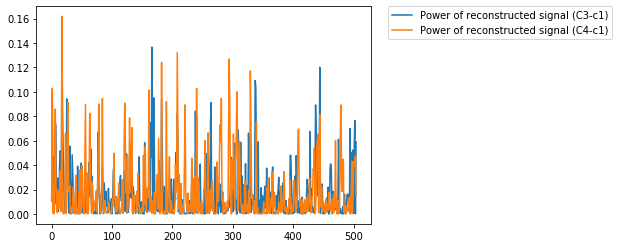

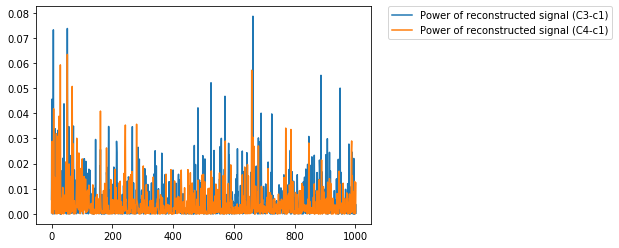

In [34]:
gumpy.plot.reconstruct_without_approx(
    [details_c3_c2[4], details_c4_c2[4]], 
    ['C3-c1', 'C4-c1'], level=6)

gumpy.plot.reconstruct_without_approx(
    [details_c3_c1[5], details_c4_c1[5]], 
    ['C3-c1', 'C4-c1'], level=6)

([array([-0.04379641,  0.17916636, -0.15634663, ...,  0.05339261,
         -0.05486782,  0.01305731]),
  array([-0.01783179,  0.0415965 , -0.07318729, ...,  0.03480512,
         -0.01006542,  0.00087816])],
 <Figure size 432x288 with 1 Axes>)

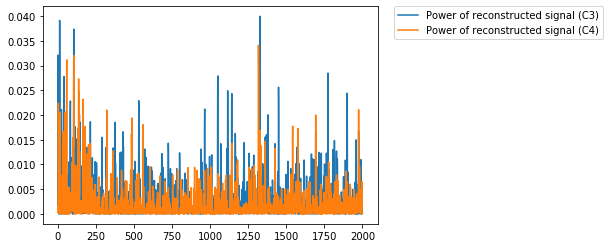

In [35]:
gumpy.plot.reconstruct_with_approx(
    [details_c3_c1[5], details_c4_c1[5]],
    ['C3', 'C4'], wavelet=wavelet)